#### 라이브러리와 app 데이터 세트 로딩

In [33]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

#import warning
%matplotlib inline

#warning.ignorewarning(...)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

##### 코랩 버전은 Google Drive에서 데이터 세트를 로딩

In [2]:
## colab 버전은 csv 데이터 세트를 google drive에서 로딩 해야 합니다. 이를 위해 google drive를 colab에 mount 수행. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
default_dir = "/content/gdrive/My Drive/ADML/data"
app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))

In [4]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
app_train.shape, app_test.shape

((307511, 122), (48744, 121))

#### TARGET 값 분포 및 AMT_INCOME_TOTAL 값 Histogram
* TARGET값 별 분포도, Pandas, Matplotlib, Seaborn으로 histogram 표현

In [6]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [7]:
app_train['TARGET'].value_counts()/app_train.shape[0]

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

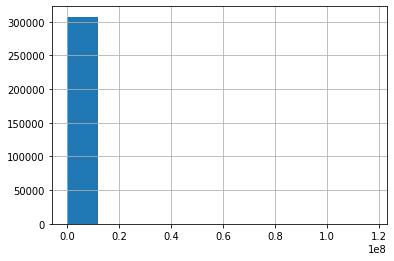

In [8]:
app_train['AMT_INCOME_TOTAL'].hist()
# plt.hist(app_train['AMT_INCOME_TOTAL'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


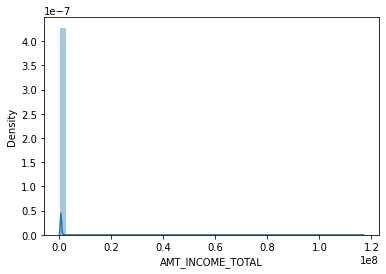

In [9]:
sns.distplot(app_train['AMT_INCOME_TOTAL'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


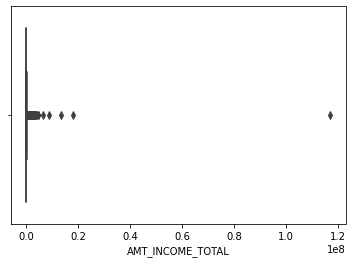

In [10]:
sns.boxplot(app_train['AMT_INCOME_TOTAL'])

#### AMT_INCOME_TOTAL이 1000000 이하인 값에 대한 분포도 
* boolean indexing으로 filtering 후 histogram 표현

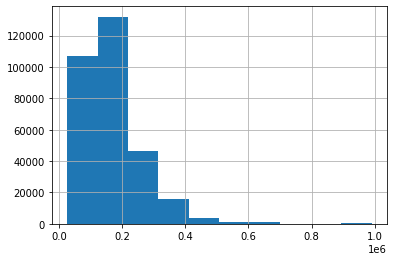

In [11]:
# boolean indexing 으로 filtering 적용 
app_train[app_train['AMT_INCOME_TOTAL'] < 1000000]['AMT_INCOME_TOTAL'].hist()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


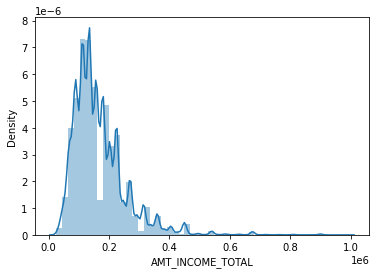

In [12]:
# distplot으로 histogram 표현 
sns.distplot(app_train[app_train['AMT_INCOME_TOTAL'] < 1000000]['AMT_INCOME_TOTAL'])

#### TARGET 값에 따른 AMT_INCOME_TOTAL값 분포도 비교
* distplot과 violinplot 시각화
* plt.subplots() 기반으로 seaborn의 distplot과 violinplot으로 분포도 비교 시각화

In [13]:
cond1 = (app_train['TARGET'] == 1)
cond0 = (app_train['TARGET'] == 0)
cond_amt = (app_train['AMT_INCOME_TOTAL'] < 500000)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


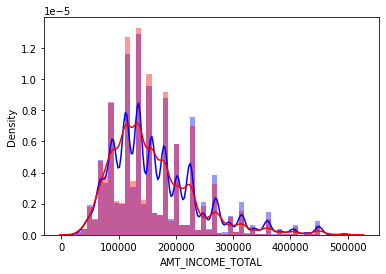

In [14]:
sns.distplot(app_train[cond0 & cond_amt]['AMT_INCOME_TOTAL'], label = 0, color = 'blue')
sns.distplot(app_train[cond1 & cond_amt]['AMT_INCOME_TOTAL'], label = 1, color = 'red')

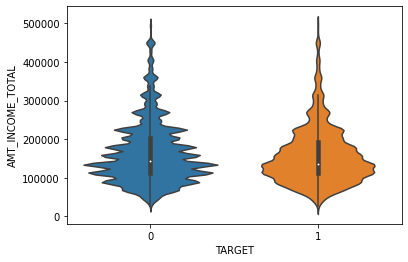

In [15]:
sns.violinplot(x = 'TARGET', y = 'AMT_INCOME_TOTAL', data = app_train[cond_amt])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


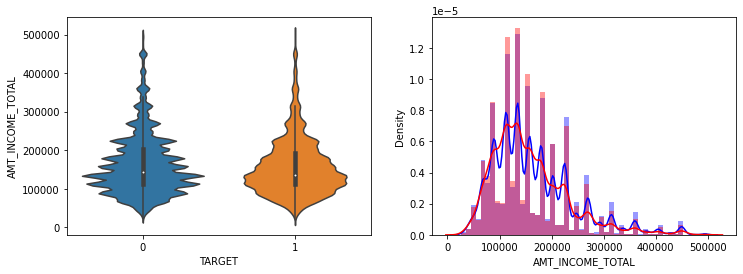

In [16]:
# fig -> 전체 컨트롤, axs -> 개별 축 컨트롤
fig, axs = plt.subplots(figsize = (12,4), nrows = 1, ncols = 2, squeeze = False)

sns.violinplot(x = 'TARGET', y = 'AMT_INCOME_TOTAL', data = app_train[cond_amt], ax = axs[0][0])

sns.distplot(app_train[cond0 & cond_amt]['AMT_INCOME_TOTAL'], label = 0, color = 'blue', ax = axs[0][1])
sns.distplot(app_train[cond1 & cond_amt]['AMT_INCOME_TOTAL'], label = 1, color = 'red', ax = axs[0][1])

In [17]:
# 시각화 함수화
def show_column_hist_by_target(df, column, is_amt=False):
    
    cond1 = (df['TARGET'] == 1)
    cond0 = (df['TARGET'] == 0)

    fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
    # is_amt가 True이면 < 500000 조건으로 filtering
    cond_amt = True
    if is_amt:
        cond_amt = df[column] < 500000
    
    sns.violinplot(x='TARGET', y=column, data=df[cond_amt], ax=axs[0][0] )
    sns.distplot(df[cond0 & cond_amt][column], ax=axs[0][1], label='0', color='blue')
    sns.distplot(df[cond1 & cond_amt][column], ax=axs[0][1], label='1', color='red')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


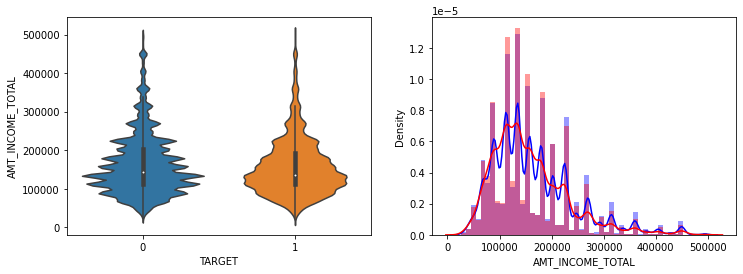

In [18]:
show_column_hist_by_target(app_train, 'AMT_INCOME_TOTAL', is_amt=True)

#### app_train과 app_test를 합쳐서 한번에 데이터 preprocessing 수행. 

In [19]:
app_train.shape, app_test.shape

((307511, 122), (48744, 121))

In [20]:
# 합치려는 df를 리스트로 묶어야 함
apps = pd.concat([app_train, app_test])
apps.shape

(356255, 122)

#### Object feature들을 Label Encoding
* pandas의 factorize()를 이용

In [21]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(66), int64(40), object(16)
memory usage: 334.3+ MB


In [22]:
object_columns = apps.dtypes[apps.dtypes == 'object'].index.tolist()
object_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [23]:
for column in object_columns:
  apps[column] = pd.factorize(apps[column])[0]

In [24]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(66), int64(56)
memory usage: 334.3 MB


#### Null값 일괄 변환

In [25]:
apps.isnull().sum().head(100)

SK_ID_CURR                           0
TARGET                           48744
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         36
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                      0
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     235241
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [26]:
# -999로 모든 컬럼들의 Null값 변환
apps = apps.fillna(-999)

In [27]:
apps.isnull().sum().head(100)

SK_ID_CURR                      0
TARGET                          0
NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT                      0
AMT_ANNUITY                     0
AMT_GOODS_PRICE                 0
NAME_TYPE_SUITE                 0
NAME_INCOME_TYPE                0
NAME_EDUCATION_TYPE             0
NAME_FAMILY_STATUS              0
NAME_HOUSING_TYPE               0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
OWN_CAR_AGE                     0
FLAG_MOBIL                      0
FLAG_EMP_PHONE                  0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_PHONE                      0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
CNT_FAM_MEMBER

#### 학습 데이터와 테스트 데이터 다시 분리

In [28]:
app_train = apps[apps['TARGET'] != -999]
app_test = apps[apps['TARGET'] == -999]
app_train.shape, app_test.shape

((307511, 122), (48744, 122))

In [29]:
app_test = app_test.drop('TARGET', axis = 1, inplace = False)
app_test.shape

(48744, 121)

#### 학습 데이터를 검증 데이터로 분리하고 LGBM Classifier로 학습 수행. 
* 피처용 데이터와 타겟 데이터 분리
* 학습용/검증용 데이터 세트 분리

In [30]:
ftr_app = app_train.drop(['SK_ID_CURR', 'TARGET'], axis = 1)
target_app = app_train['TARGET']

In [31]:
train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size = 0.3, random_state = 2020)
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

((215257, 120), (92254, 120), (215257,), (92254,))

In [32]:
clf = LGBMClassifier(
        n_jobs=-1, # 모든 process를 사용
        n_estimators=1000, # iteration을 1000번
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
eval_metric= 'auc', verbose= 100, early_stopping_rounds= 50) # 100번 마다 출력

Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.752239	training's binary_logloss: 0.250361	valid_1's auc: 0.744198	valid_1's binary_logloss: 0.251609
[200]	training's auc: 0.771653	training's binary_logloss: 0.243534	valid_1's auc: 0.754199	valid_1's binary_logloss: 0.247513
[300]	training's auc: 0.784972	training's binary_logloss: 0.239351	valid_1's auc: 0.757636	valid_1's binary_logloss: 0.246218
[400]	training's auc: 0.796437	training's binary_logloss: 0.235986	valid_1's auc: 0.759327	valid_1's binary_logloss: 0.245638
[500]	training's auc: 0.806414	training's binary_logloss: 0.233059	valid_1's auc: 0.759816	valid_1's binary_logloss: 0.245448
[600]	training's auc: 0.815154	training's binary_logloss: 0.23033	valid_1's auc: 0.759934	valid_1's binary_logloss: 0.245364
Early stopping, best iteration is:
[569]	training's auc: 0.81267	training's binary_logloss: 0.231137	valid_1's auc: 0.759984	valid_1's binary_logloss: 0.245366


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.02, max_depth=12,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=32, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=-1,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

##### Feature importance 시각화 

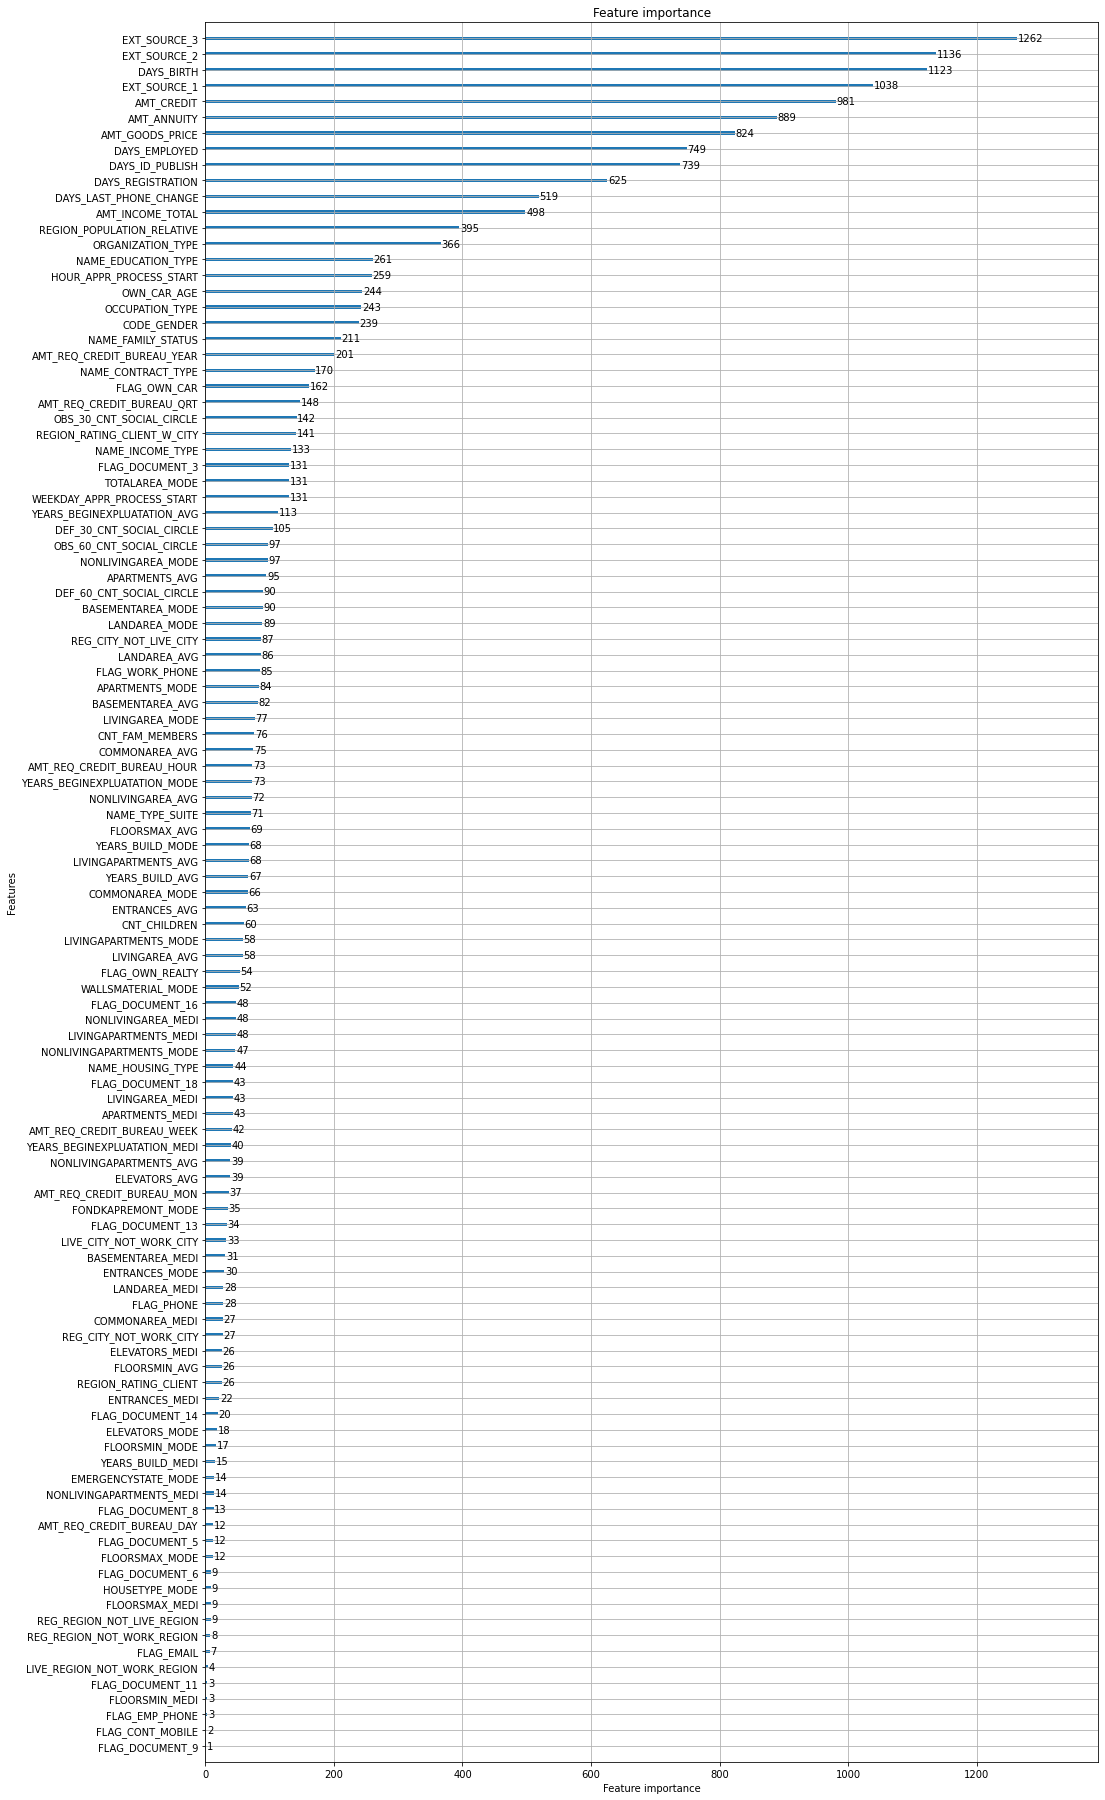

In [34]:
plot_importance(clf, figsize=(16, 32))

#### 학습된 Classifier를 이용하여 테스트 데이터을 예측하고 결과를 Kaggle로 Submit 수행. 

In [36]:
clf.predict_proba(app_test.drop(['SK_ID_CURR'], axis = 1))

array([[0.9703357 , 0.0296643 ],
       [0.88534333, 0.11465667],
       [0.98398167, 0.01601833],
       ...,
       [0.97145979, 0.02854021],
       [0.94313375, 0.05686625],
       [0.82184673, 0.17815327]])

In [37]:
preds = clf.predict_proba(app_test.drop(['SK_ID_CURR'], axis = 1))[:,1]

In [38]:
app_test['TARGET'] = preds
app_test['TARGET'].head()

0    0.029664
1    0.114657
2    0.016018
3    0.044586
4    0.148616
Name: TARGET, dtype: float64

##### 코랩 버전은 Google Drive로 예측 결과 CSV를 생성.

In [39]:
# SK_ID_CURR과 TARGET 값만 csv 형태로 생성. 코랩 버전은 구글 드라이브 절대 경로로 입력  
default_dir = "/content/gdrive/My Drive/ADML/result"
app_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir, 'app_baseline_01.csv'), index=False)